In [4]:
import ipywidgets
import IPython.display
import matplotlib.pyplot as plt
# homemade stuff
import dataloader
import utilities
import features
import pitchspace

PATH = "/home/max/ET-TI/Masterarbeit/mirdata/"  # path to datasets
SAMPLERATE = 22050
data = {} # global dictionary that is needed to access data from callback

def update_dropdown_id_options(*args):
    selected_split = dropdown_split.value
    data["dataset"] = dataloader.MIRDataset("beatles",basepath=PATH, split_nr=selected_split)
    dropdown_id.options = list(data["dataset"].getTrackList().keys())
    dropdown_id.value = list(data["dataset"].getTrackList().keys())[0]

def update_selected_track_id(*args):
    textbox_track_id.value = data["dataset"].getTrackList()[dropdown_id.value]

def on_control_change(change):  
    # change some controls according to updates
    pass
    # plotData(range_slider.value,beat_alignment.value,chroma_type.value)

def loadData(_):
    controls_container.children = [selection]  # hide controls
    audiopath,target = data["dataset"][dropdown_id.value]
    timevector,sig = utilities.loadAudio(audiopath,0,30)
    data['beats'] = features.beats(sig,False,0.05)
    data['path'] = audiopath
    data['target'] = target
    # data['est_intervals'],data['est_labels'] = pitchspace.predictLabels(data['timevector'],data['chroma'],data['est_keys'])

    range_slider.max = int(sig.num_samples/sig.sample_rate)
    controls_container.children = [selection, controls] # show controls 
    
def plotData(_):
    with output:
        t_min = range_slider.value[0]
        t_max = range_slider.value[1]
        IPython.display.clear_output(wait=True)
        timevector,sig = utilities.loadAudio(data['path'],t_min,t_max)
        beats = [b for b in data['beats'] if t_min < b and b < t_max]
        try:
            t,chroma = features.crpChroma(sig,nCRP=22,filter_scale=1)
        except TypeError:
            t,chroma = features.crpChroma(sig,nCRP=22,filter_scale=1)
        chroma_smoothed = utilities.smoothChromagram(t,chroma,beats)
        ic = features.intervalCategories(chroma_smoothed)
        fig,ax = plt.subplots(4,2,height_ratios=(1,4,4,2),width_ratios=(10,2),figsize=(14,5))
        utilities.plotChordAnnotations(ax[0,0],data['target'],(t_min,t_max))
        utilities.plotChromagram(ax[1,0],t,chroma,beats)
        ax[1,0].set_xlim((t_min,t_max))
        # utilities.plotChromagram(ax[2,0],t,chroma_smoothed) 
        # ax[2,0].set_xlim((t_min,t_max))
        # utilities.plotIntervalCategories(ax[3,0],t,ic)
        # ax[3,0].set_xlim((t_min,t_max))
        for i in range(4):
            ax[i,1].axis('off')
        plt.show()

#Create widgets
output = ipywidgets.Output()
dropdown_dataset = ipywidgets.Dropdown(options=["beatles","RWC"],value = "beatles",description='Dataset:',
                                  layout=ipywidgets.Layout(width='20%'),disabled=False)
dropdown_split = ipywidgets.Dropdown(options=[1, 2, 3, 4, 5, 6, 7],value = 3,description='Split:',
                                  layout=ipywidgets.Layout(width='15%'),disabled=False)
dropdown_id = ipywidgets.Dropdown(description='Track ID:',disabled=False,layout=ipywidgets.Layout(width='20%'))
textbox_track_id = ipywidgets.Text(description='',disabled=True)
button_load = ipywidgets.Button(description='Load Track')
# widgets for selecting data
button_load.on_click(loadData)
selection = ipywidgets.HBox([dropdown_dataset,dropdown_split, dropdown_id,textbox_track_id, button_load])

# widgets for controlling the plot
range_slider = ipywidgets.FloatRangeSlider(value=[0, 20], min=0, max=10, step=1, description='Time Range:', readout_format='.1f')
button_plot = ipywidgets.Button(description='Plot data')
int_slider = ipywidgets.IntSlider(0,0,10,1,description='Beat')
controls = ipywidgets.HBox([range_slider,button_plot,int_slider])
button_plot.on_click(plotData)
# Initially hide the controls
controls_container = ipywidgets.VBox([selection])

dropdown_split.observe(update_dropdown_id_options, 'value')
dropdown_id.observe(update_selected_track_id, 'value')

int_slider.observe(on_control_change, 'value')

# initialize dropdown menus
update_dropdown_id_options()
update_selected_track_id()
IPython.display.display(controls_container)
IPython.display.display(output)

Output()

KeyError: 'target'

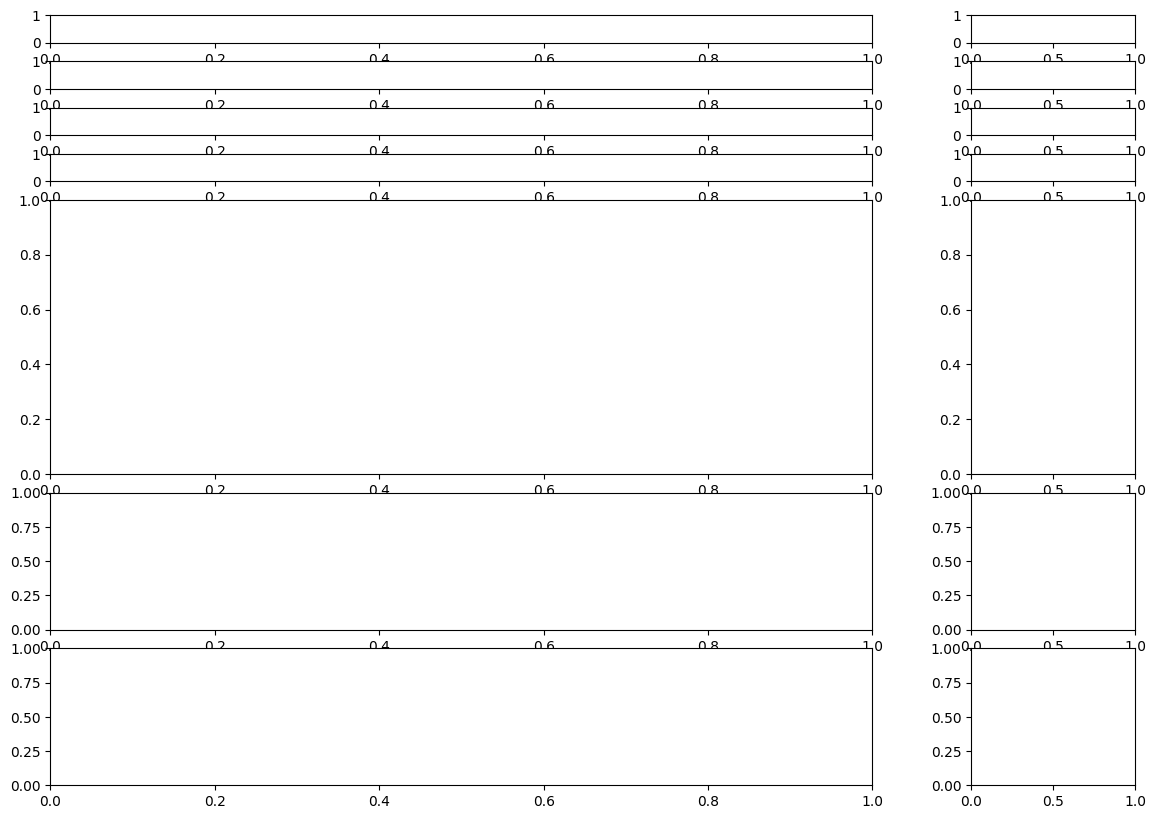

In [2]:
t_min = range_slider.value[0]
t_max = range_slider.value[1]
IPython.display.clear_output(wait=True)
fig,ax = plt.subplots(7,2,height_ratios=(1,1,1,1,10,5,5),width_ratios=(10,2),figsize=(14,10))
utilities.plotChordAnnotations(ax[0,0],data['target'],(t_min,t_max))
utilities.plotChordAnnotations(ax[1,0],(data['est_intervals'][0],data['est_labels'][0]),(t_min,t_max))
utilities.plotChordAnnotations(ax[2,0],(data['est_intervals'][1],data['est_labels'][1]),(t_min,t_max))
utilities.plotChordAnnotations(ax[3,0],(data['est_intervals'][2],data['est_labels'][2]),(t_min,t_max))
utilities.plotChromagram(ax[4,0],data['timevector'],data['chroma'])
ax[4,0].set_xlim((t_min,t_max))
utilities.plotComplexityFeatures(ax[5,0],ax[5,1],data['timevector'],data['chroma_complexity'])
ax[5,0].set_xlim((t_min,t_max))
utilities.plotIntervalCategories(ax[6,0],data['timevector'],data['interval_categories'])
ax[6,0].set_xlim((t_min,t_max))
for i in range(7):
    ax[i,1].axis('off')

Chord estimation with pitch space with a beat segment of the Chromagram

In [ ]:
# split chromagram into beat segments
bar_indices = []
for beat0, beat1 in itertools.pairwise(downbeats):
    if beat0 < start:
        continue
    elif beat1 > stop:
        break
    idx0 = np.where(t >= beat0)[0][0]
    idx1 = np.where(t >= beat1)[0][0]
    bar_indices.append((idx0,idx1))

# select a bar
bar = 0
i_0 = bar_indices[bar][0]
i_1 = bar_indices[bar][1]
chroma_temp = chroma[i_0:i_1]
t_temp = t[i_0:i_1]
rho_F,rho_FR,rho_TR,rho_DR = pitchspace.transformChroma(chroma_temp)

# filter pc energy up to the selected bar!
pc_energy = pitchspace.getPitchClassEnergyProfile(chroma[:i_1],threshold=0.7,angle_weight=0.5)
pc_energy_filtered = pitchspace.filterPitchClassEnergy(pc_energy,alpha=0.96)
keys = np.argsort(pc_energy_filtered[i_0:])
keys = keys[:,-1]  # pick the most likely keys
labels = pitchspace.estimateChordLabels(t_temp, chroma_temp,keys)
est_intervals,est_labels = utilities.createChordIntervals(t_temp,labels)

complexity_features = [
                features.sumChromaDifferences(chroma_temp),
                features.angularDeviation(chroma_temp),
                features.flatness(chroma_temp),
                features.shannonEntropy(chroma_temp),
                features.negativeSlope(chroma_temp),
                features.nonSparseness(chroma_temp),
                features.standardDeviation(chroma_temp)
]
interval_categories = features.intervalCategories(chroma_temp)
# VISUALIZATION 
fig,ax = plt.subplots(4,2,height_ratios=(1,1,7,7),width_ratios=(7,7),figsize=(9,5))
utilities.plotChordAnnotations(ax[0,0],target,(t[i_0],t[i_1]))
ax[0,1].axis("off")
ax[0,1].text(0,0.2,"<- Annotations")
utilities.plotChordAnnotations(ax[1,0],(est_intervals,est_labels),(t[i_0],t[i_1]))
ax[1,1].axis("off")
ax[1,1].text(0,0.2,"<- Predictions")
utilities.plotChromagram(ax[2,0],t[i_0:i_1],chroma[i_0:i_1]);
ax[2,0].set_xlim(t[i_0],t[i_1]);
ax[2,0].set_xlabel("")
ax[2,0].set_xticklabels([])
utilities.plotIntervalCategories(ax[2,1],t_temp,interval_categories)
ax[2,1].set_xlabel("")
ax[2,1].set_xticklabels([])
utilities.plotComplexityFeatures(ax[3,0],ax[3,1],t_temp,complexity_features)
ax[3,0].set_xlabel("Time in s")

current_pitch_class = -1 # initialization
for i in range(t_temp.shape[0]):
    if current_pitch_class != keys[i]:
        current_pitch_class = keys[i]
        fig,ax = plt.subplots(1,4,figsize=(9,9/4))
        pitchspace.plotDiatonicTriads(ax,current_pitch_class)    
    z = rho_F[i] * 1j
    ax[0].plot([z.real], [z.imag], "x",color = utilities.getColor(labels[i]), markersize=5)
    z = rho_FR[i, current_pitch_class] * 1j
    ax[1].plot([z.real], [z.imag], "x",color = utilities.getColor(labels[i]), markersize=5)
    z = rho_TR[i, current_pitch_class] * 1j
    ax[2].plot([z.real], [z.imag], "x",color = utilities.getColor(labels[i]), markersize=5)

    